Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

[link text](https://)### Importing all the important libraries

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Add,Dropout, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalAveragePooling2D

from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
root_path = '/content/gdrive/MyDrive/Melanoma_Assignment_Data'
data_dir_train = pathlib.Path(root_path + '/Train')
data_dir_test = pathlib.Path(root_path + '/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


In [5]:
File_Path = '/content/gdrive/MyDrive/Melanoma_Assignment_Data/Train/'

### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

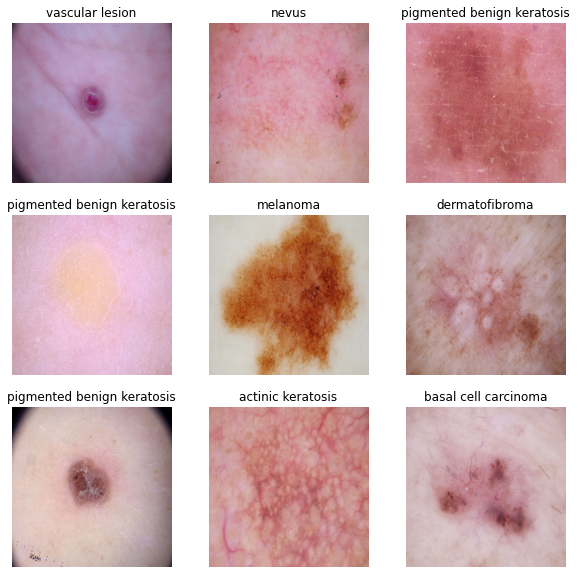

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [12]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break


(32, 180, 180, 3)
(32,)


The image_batch is a tensor of the shape (32, 180, 180, 3). 

This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

In [13]:
### Your code goes here
preprocessing_layers = [
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3))
]

In [14]:
input_shape = (180,180,3)
lr = 1e-5
init = 'normal'
activ = 'relu'
num_classes = len(class_names)

model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Activation('relu'))
model.add(Dense(num_classes))
model.add(Activation('sigmoid'))


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [15]:
### Todo, choose an appropirate optimiser and loss function
optimizer = 'adam'
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

In [16]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

### Train the model

In [17]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - 115s 2s/step - loss: 2.0975 - accuracy: 0.2160 - val_loss: 1.9195 - val_accuracy: 0.2707
Epoch 2/20
56/56 [==============================] - 2s 38ms/step - loss: 1.9126 - accuracy: 0.3052 - val_loss: 1.8120 - val_accuracy: 0.3333
Epoch 3/20
56/56 [==============================] - 2s 38ms/step - loss: 1.6763 - accuracy: 0.3968 - val_loss: 1.6243 - val_accuracy: 0.4631
Epoch 4/20
56/56 [==============================] - 2s 38ms/step - loss: 1.5368 - accuracy: 0.4626 - val_loss: 1.5473 - val_accuracy: 0.5168
Epoch 5/20
56/56 [==============================] - 2s 38ms/step - loss: 1.4202 - accuracy: 0.5262 - val_loss: 1.3653 - val_accuracy: 0.5257
Epoch 6/20
56/56 [==============================] - 2s 38ms/step - loss: 1.3256 - accuracy: 0.5346 - val_loss: 1.3686 - val_accuracy: 0.4989
Epoch 7/20
56/56 [==============================] - 2s 38ms/step - loss: 1.2686 - accuracy: 0.5580 - val_loss: 1.3411 - val_accuracy: 0.5324
Epoch 8/20
56/56 [======

### Visualizing training results

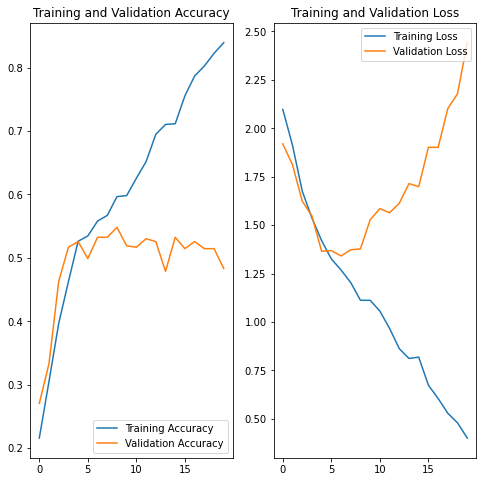

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

In [19]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)


14/14 [==============================] - 0s 17ms/step - loss: 2.4418 - accuracy: 0.4832
Accuracy:  0.8577008843421936
Validation Accuracy:  0.48322147130966187
Loss:  0.3617425858974457
Validation Loss 2.441801071166992


**Observation:** 
The plots show that training accuracy and validation accuracy are off by large margins, and the model has achieved only around 50% accuracy on the validation set.

Lets try to increase the overall performance of the model.

### Write your findings here

In [20]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
  layers.RandomRotation(0.2)
])


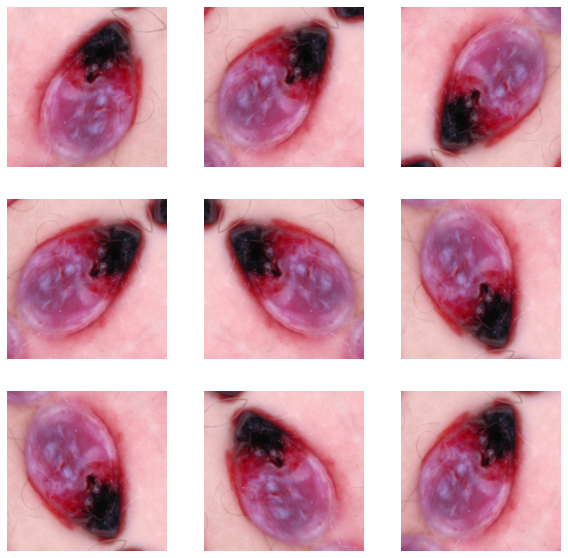

In [21]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [22]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])


### Compiling the model

In [23]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

### Training the model

In [25]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
batch_size = 10
history = model.fit(train_ds,
  epochs = epochs, verbose = 1, validation_data=val_ds )

Epoch 1/20
56/56 [==============================] - 4s 51ms/step - loss: 2.1696 - accuracy: 0.2455 - val_loss: 1.9343 - val_accuracy: 0.2685
Epoch 2/20
56/56 [==============================] - 3s 46ms/step - loss: 1.8083 - accuracy: 0.3426 - val_loss: 1.5785 - val_accuracy: 0.4407
Epoch 3/20
56/56 [==============================] - 3s 46ms/step - loss: 1.6039 - accuracy: 0.4314 - val_loss: 1.7133 - val_accuracy: 0.4139
Epoch 4/20
56/56 [==============================] - 3s 45ms/step - loss: 1.4664 - accuracy: 0.4844 - val_loss: 1.3909 - val_accuracy: 0.5168
Epoch 5/20
56/56 [==============================] - 3s 46ms/step - loss: 1.4200 - accuracy: 0.5117 - val_loss: 1.4606 - val_accuracy: 0.4966
Epoch 6/20
56/56 [==============================] - 3s 46ms/step - loss: 1.4092 - accuracy: 0.5022 - val_loss: 1.3770 - val_accuracy: 0.5347
Epoch 7/20
56/56 [==============================] - 3s 45ms/step - loss: 1.3291 - accuracy: 0.5296 - val_loss: 1.3590 - val_accuracy: 0.5257
Epoch 8/20
56

### Visualizing the results

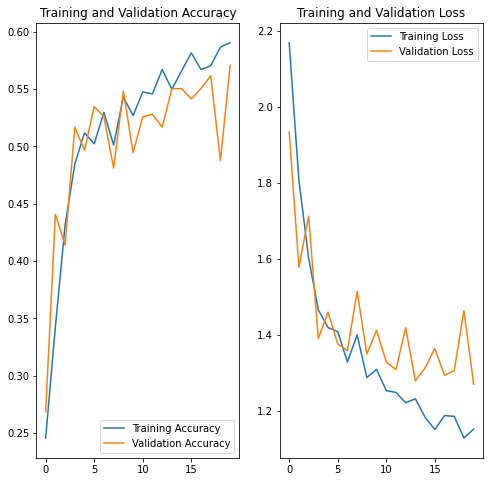

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [27]:
print("Accuracy: ", accuracy)
print("Validation Accuracy: ",val_acc)
print("Loss: ",loss)
print("Validation Loss", val_loss)

Accuracy:  0.8577008843421936
Validation Accuracy:  [0.268456369638443, 0.44071587920188904, 0.413870245218277, 0.5167785286903381, 0.4966442883014679, 0.5346755981445312, 0.5257270932197571, 0.48098433017730713, 0.5480984449386597, 0.49440714716911316, 0.5257270932197571, 0.5279642343521118, 0.5167785286903381, 0.5503355860710144, 0.5503355860710144, 0.5413870215415955, 0.5503355860710144, 0.5615212321281433, 0.48769575357437134, 0.5704697966575623]
Loss:  [2.1695730686187744, 1.8082889318466187, 1.6039239168167114, 1.4663602113723755, 1.4200036525726318, 1.4091575145721436, 1.3290764093399048, 1.4003407955169678, 1.2882815599441528, 1.3096959590911865, 1.2539845705032349, 1.248953104019165, 1.2219210863113403, 1.2322757244110107, 1.1835516691207886, 1.1516047716140747, 1.1879549026489258, 1.1861923933029175, 1.12899649143219, 1.1527245044708252]
Validation Loss [1.9343421459197998, 1.5784904956817627, 1.71328866481781, 1.3909162282943726, 1.4606295824050903, 1.3770420551300049, 1.359

In [28]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

14/14 [==============================] - 0s 11ms/step - loss: 1.2704 - accuracy: 0.5705
Accuracy:  0.6199776530265808
Validation Accuracy:  0.5704697966575623
Loss:  1.034972906112671
Validation Loss 1.27040696144104


#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

**Observation:**
After applying data augmentation and tf.keras.layers.Dropout, there is less overfitting than before, and training and validation accuracy are closer aligned

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<Figure size 720x720 with 0 Axes>

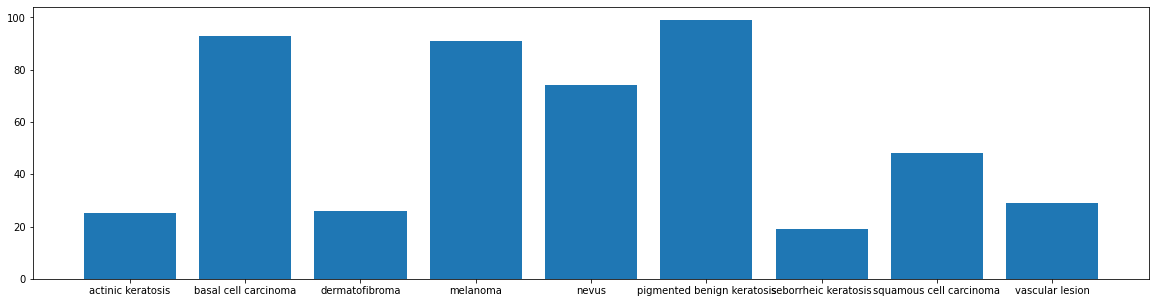

In [29]:
## Your code goes here.
import matplotlib.pyplot as plt
data = dict()

for i in class_names:
    data[i] = []

plt.figure(figsize=(10, 10))
for images, labels in train_ds:
    for i in range(9):
        data[class_names[labels[i]]].append(images[i].numpy().astype("uint8"))

for i in data:
    data[i] = len(data[i]) 

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(5)

plt.bar(range(len(data)), list(data.values()), align='center')
plt.xticks(range(len(data)), list(data.keys()))
plt.show()

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?

**Answer**:Seborrheic keratosis and Actinic Keratosos

#### - Which classes dominate the data in terms proportionate number of samples?
**Answer**:

Pigmented benign keratosis class dominates the data of count more than 100 in training

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [30]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [32]:

if not os.path.exists(File_Path):
    print("The source directory you specified does not exist.")
else:
    print("Exists")

Exists


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [33]:
path_to_training_dataset=File_Path
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma_Assignment_Data/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F22ED90EC50>: 100%|██████████| 500/500 [00:21<00:00, 23.41 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma_Assignment_Data/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F22EA5A39D0>: 100%|██████████| 500/500 [00:18<00:00, 26.76 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma_Assignment_Data/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F22EA5A3650>: 100%|██████████| 500/500 [00:17<00:00, 28.15 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma_Assignment_Data/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F22ED845A10>: 100%|██████████| 500/500 [01:32<00:00,  5.41 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma_Assignment_Data/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=2117x1988 at 0x7F23EDC28ED0>: 100%|██████████| 500/500 [01:20<00:00,  6.21 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma_Assignment_Data/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F22EA50D950>: 100%|██████████| 500/500 [00:17<00:00, 27.95 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma_Assignment_Data/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F22ED8C5250>: 100%|██████████| 500/500 [00:41<00:00, 12.02 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma_Assignment_Data/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F22EA584ED0>: 100%|██████████| 500/500 [00:18<00:00, 27.71 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma_Assignment_Data/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F22ED894FD0>: 100%|██████████| 500/500 [00:18<00:00, 27.22 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [34]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to 

---

the original training data.

In [35]:
from glob import glob

In [36]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/Melanoma_Assignment_Data/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030877.jpg_ac9653c2-0549-454a-9d87-f289a17c19f9.jpg',
 '/content/gdrive/MyDrive/Melanoma_Assignment_Data/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033358.jpg_c17f1e92-f7ae-450e-9cb5-7a32a7a8bbda.jpg',
 '/content/gdrive/MyDrive/Melanoma_Assignment_Data/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026729.jpg_efac8e0e-8743-404e-94b1-63c4e8bd263d.jpg',
 '/content/gdrive/MyDrive/Melanoma_Assignment_Data/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028314.jpg_5f428276-69eb-48f3-847e-afda5e75517f.jpg',
 '/content/gdrive/MyDrive/Melanoma_Assignment_Data/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030825.jpg_e27482d9-853b-40bf-b9c9-12174085826d.jpg',
 '/content/gdrive/MyDrive/Melanoma_Assignment_Data/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031335.jpg_0266c207-7b0e-459a-b683-a7b9d

In [37]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [38]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [39]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df =df2 # original_df.append(df2)

In [40]:
new_df['Label'].value_counts()

actinic keratosis             500
seborrheic keratosis          500
squamous cell carcinoma       500
nevus                         500
melanoma                      500
pigmented benign keratosis    500
dermatofibroma                500
vascular lesion               500
basal cell carcinoma          500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [41]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [42]:
data_dir_train=File_Path
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset ='training',## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [43]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [44]:
## your code goes here
model = Sequential()

# Increse the model size by adding another 32 layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))

# Max Pool size of 2*2
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
# Adding Dropout Layer
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(9, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 90, 90, 32)       128       
 ormalization)                                                   
                                                                 
 dropout_1 (Dropout)         (None, 90, 90, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 64)      

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [45]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


#### **Todo:**  Train your model

In [46]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 35s 189ms/step - loss: 1.9333 - accuracy: 0.3680 - val_loss: 1.9503 - val_accuracy: 0.3682
Epoch 2/30
169/169 [==============================] - 32s 183ms/step - loss: 1.5921 - accuracy: 0.4518 - val_loss: 1.9309 - val_accuracy: 0.3719
Epoch 3/30
169/169 [==============================] - 32s 181ms/step - loss: 1.3527 - accuracy: 0.5158 - val_loss: 1.3046 - val_accuracy: 0.5041
Epoch 4/30
169/169 [==============================] - 31s 180ms/step - loss: 1.2075 - accuracy: 0.5645 - val_loss: 1.5660 - val_accuracy: 0.5338
Epoch 5/30
169/169 [==============================] - 32s 186ms/step - loss: 1.1042 - accuracy: 0.6011 - val_loss: 1.4991 - val_accuracy: 0.4915
Epoch 6/30
169/169 [==============================] - 32s 182ms/step - loss: 0.9999 - accuracy: 0.6380 - val_loss: 1.0095 - val_accuracy: 0.6325
Epoch 7/30
169/169 [==============================] - 31s 179ms/step - loss: 0.9507 - accuracy: 0.6610 - val_loss: 1.5962 - val_ac

#### **Todo:**  Visualize the model results

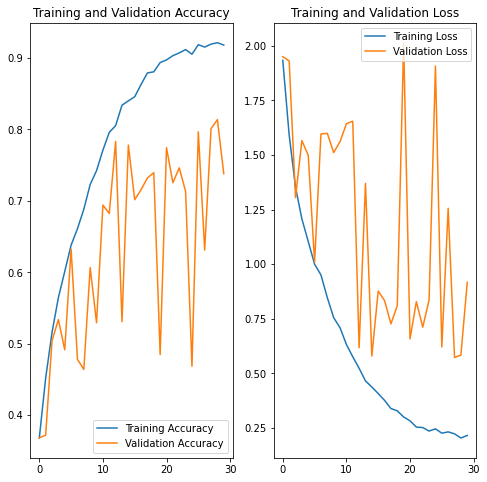

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



In [48]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

43/43 [==============================] - 6s 113ms/step - loss: 0.9169 - accuracy: 0.7379
Accuracy:  0.8594213724136353
Validation Accuracy:  0.7379361391067505
Loss:  0.40932780504226685
Validation Loss 0.9168971180915833


**Observation**

The class rebalance helped in reducing overfititng of the data and thus the loss; Also maintains the accuracy of the model with the help of Batch Normalization and Augumentation which really helped in carry forward.